## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp002'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 65 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([65, 224, 224])

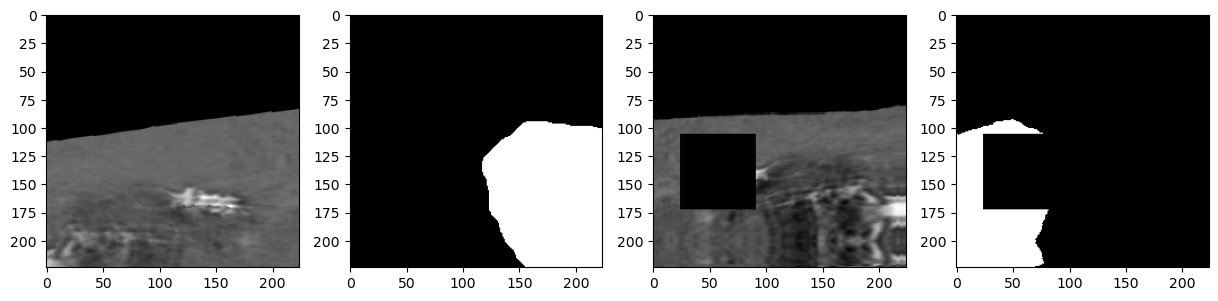

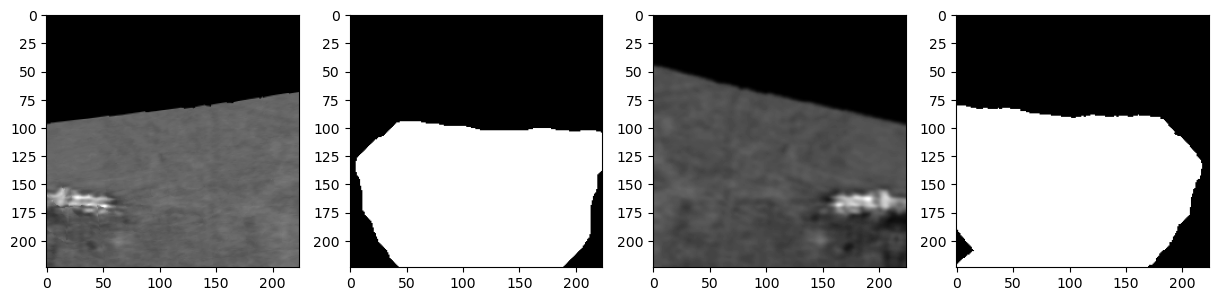

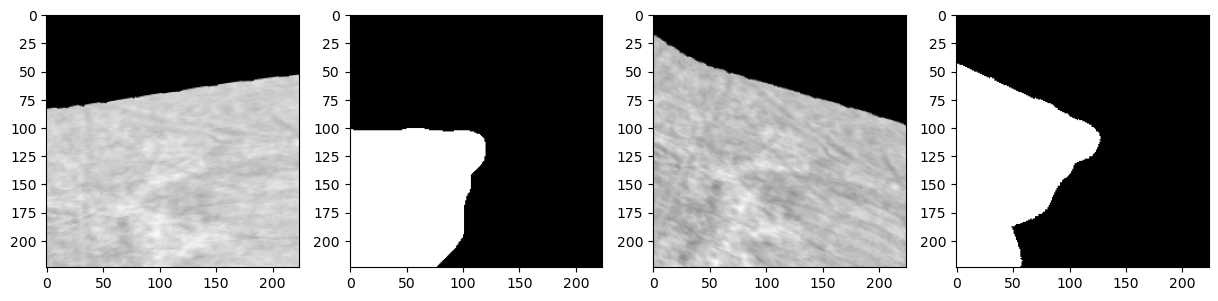

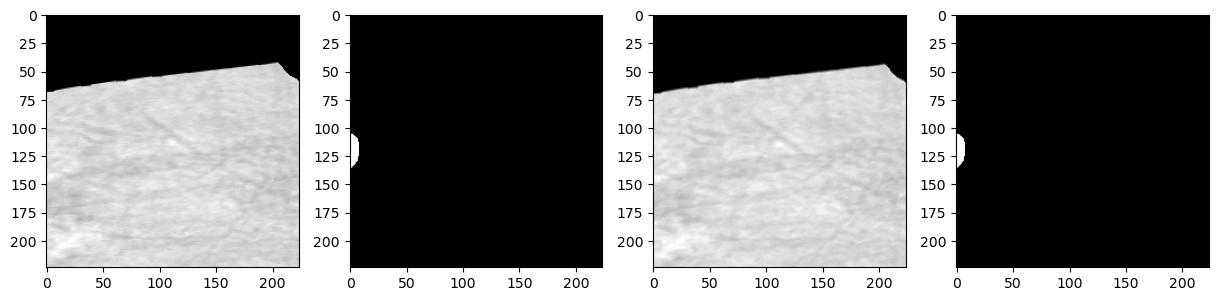

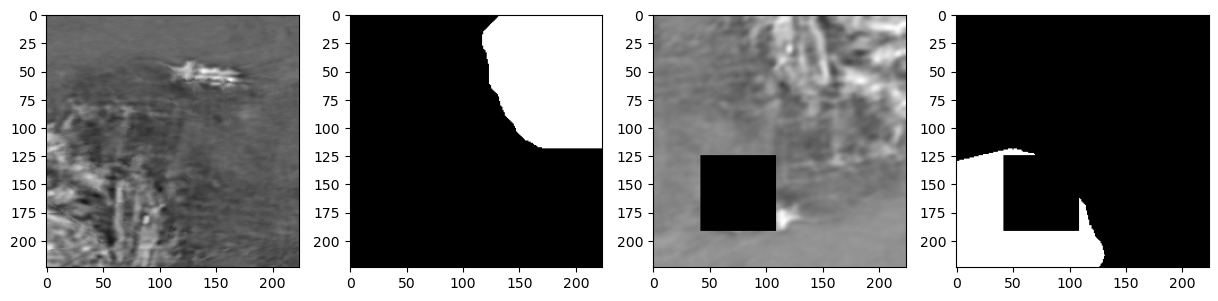

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1421054784615985
th: 0.15, fbeta: 0.1421292379045786
th: 0.2, fbeta: 0.14216435024562565
th: 0.25, fbeta: 0.142650683926222
th: 0.3, fbeta: 0.20467232823877796
th: 0.35, fbeta: 0.21190512171092965
th: 0.4, fbeta: 0.16800144658101393
th: 0.45, fbeta: 0.06560235654755563


best_th: 0.35, fbeta: 0.21190512171092965
Epoch 1 - avg_train_loss: 0.5982  avg_val_loss: 0.4643  time: 203s
Epoch 1 - avgScore: 0.2119
Epoch 1 - Save Best Score: 0.2119 Model
Epoch 1 - Save Best Loss: 0.4643 Model


th: 0.5, fbeta: 0.012226594479385431


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209990711732617
th: 0.15, fbeta: 0.14212190411815817
th: 0.2, fbeta: 0.14231391526062037
th: 0.25, fbeta: 0.20547596270217905
th: 0.3, fbeta: 0.2245668024011986
th: 0.35, fbeta: 0.17810458885796623
th: 0.4, fbeta: 0.03878807555750966
th: 0.45, fbeta: 0.002902233628265927


best_th: 0.3, fbeta: 0.2245668024011986
Epoch 2 - avg_train_loss: 0.4256  avg_val_loss: 0.4296  time: 207s
Epoch 2 - avgScore: 0.2246
Epoch 2 - Save Best Score: 0.2246 Model
Epoch 2 - Save Best Loss: 0.4296 Model


th: 0.5, fbeta: 0.0002398356881926438


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.22041533201662392
th: 0.15, fbeta: 0.23480872709481437
th: 0.2, fbeta: 0.22694315626514214
th: 0.25, fbeta: 0.14871555667537478
th: 0.3, fbeta: 0.03822818753551171
th: 0.35, fbeta: 0.0
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.15, fbeta: 0.23480872709481437
Epoch 3 - avg_train_loss: 0.2972  avg_val_loss: 0.3180  time: 205s
Epoch 3 - avgScore: 0.2348
Epoch 3 - Save Best Score: 0.2348 Model
Epoch 3 - Save Best Loss: 0.3180 Model


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30068706589505134
th: 0.15, fbeta: 0.21286543806172312
th: 0.2, fbeta: 0.05106966540472482
th: 0.25, fbeta: 0.009847257146214015
th: 0.3, fbeta: 0.001617730234874942
th: 0.35, fbeta: 4.565320438337376e-05
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.30068706589505134
Epoch 4 - avg_train_loss: 0.2373  avg_val_loss: 0.3976  time: 202s
Epoch 4 - avgScore: 0.3007
Epoch 4 - Save Best Score: 0.3007 Model
Epoch 4 - Save Best Loss: 0.3976 Model


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25281165380644854
th: 0.15, fbeta: 0.2922027729661114
th: 0.2, fbeta: 0.3403269959402345
th: 0.25, fbeta: 0.335969477830822
th: 0.3, fbeta: 0.28208076721561015
th: 0.35, fbeta: 0.20199195580092982
th: 0.4, fbeta: 0.12137534810640106
th: 0.45, fbeta: 0.04843960766311124


best_th: 0.2, fbeta: 0.3403269959402345
Epoch 5 - avg_train_loss: 0.2258  avg_val_loss: 0.3206  time: 203s
Epoch 5 - avgScore: 0.3403
Epoch 5 - Save Best Score: 0.3403 Model
Epoch 5 - Save Best Loss: 0.3206 Model


th: 0.5, fbeta: 0.007817697410357623


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3043197976798921
th: 0.15, fbeta: 0.3299410594353943
th: 0.2, fbeta: 0.2915717367740696
th: 0.25, fbeta: 0.20086180120681257
th: 0.3, fbeta: 0.11942814367298235
th: 0.35, fbeta: 0.06262858808797094
th: 0.4, fbeta: 0.031368456114311716
th: 0.45, fbeta: 0.01326881090216472


best_th: 0.15, fbeta: 0.3299410594353943
Epoch 6 - avg_train_loss: 0.2149  avg_val_loss: 0.3627  time: 202s
Epoch 6 - avgScore: 0.3299


th: 0.5, fbeta: 0.004577539720541861


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3081203807080374
th: 0.15, fbeta: 0.3268840212024906
th: 0.2, fbeta: 0.3368344581361814
th: 0.25, fbeta: 0.34056876577242073
th: 0.3, fbeta: 0.3364137176600972
th: 0.35, fbeta: 0.3242708280311906
th: 0.4, fbeta: 0.29933463472773464
th: 0.45, fbeta: 0.26356692625736533


best_th: 0.25, fbeta: 0.34056876577242073
Epoch 7 - avg_train_loss: 0.2085  avg_val_loss: 0.3615  time: 206s
Epoch 7 - avgScore: 0.3406
Epoch 7 - Save Best Score: 0.3406 Model
Epoch 7 - Save Best Loss: 0.3615 Model


th: 0.5, fbeta: 0.21484736152508524


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3061222484043476
th: 0.15, fbeta: 0.30015247571089315
th: 0.2, fbeta: 0.2779558749846909
th: 0.25, fbeta: 0.25541484692881605
th: 0.3, fbeta: 0.2277389585080873
th: 0.35, fbeta: 0.196367194322395
th: 0.4, fbeta: 0.16436374556100433
th: 0.45, fbeta: 0.12966689123079073


best_th: 0.1, fbeta: 0.3061222484043476
Epoch 8 - avg_train_loss: 0.2003  avg_val_loss: 0.3911  time: 212s
Epoch 8 - avgScore: 0.3061


th: 0.5, fbeta: 0.09507209625495379


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31117896691090796
th: 0.15, fbeta: 0.3016891129825925
th: 0.2, fbeta: 0.26421640087133097
th: 0.25, fbeta: 0.22053648057818315
th: 0.3, fbeta: 0.1763181464444957
th: 0.35, fbeta: 0.13869506113682772
th: 0.4, fbeta: 0.10808375754752376
th: 0.45, fbeta: 0.08335735253140351


best_th: 0.1, fbeta: 0.31117896691090796
Epoch 9 - avg_train_loss: 0.1948  avg_val_loss: 0.4518  time: 212s
Epoch 9 - avgScore: 0.3112


th: 0.5, fbeta: 0.0590907026234505


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32275529390244084
th: 0.15, fbeta: 0.32302710018231234
th: 0.2, fbeta: 0.30965402924784513
th: 0.25, fbeta: 0.28518334578134813
th: 0.3, fbeta: 0.25170610909082936
th: 0.35, fbeta: 0.21479731399117205
th: 0.4, fbeta: 0.17901030150585534
th: 0.45, fbeta: 0.14407787682482506


best_th: 0.15, fbeta: 0.32302710018231234
Epoch 10 - avg_train_loss: 0.1862  avg_val_loss: 0.4260  time: 212s
Epoch 10 - avgScore: 0.3230


th: 0.5, fbeta: 0.11154387848810395


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2927213929635135
th: 0.15, fbeta: 0.27746941796266367
th: 0.2, fbeta: 0.24615731305731336
th: 0.25, fbeta: 0.2052603207236607
th: 0.3, fbeta: 0.16439937749629552
th: 0.35, fbeta: 0.1285548462553836
th: 0.4, fbeta: 0.09883320312259929
th: 0.45, fbeta: 0.06991124061587246


best_th: 0.1, fbeta: 0.2927213929635135
Epoch 11 - avg_train_loss: 0.1783  avg_val_loss: 0.4750  time: 208s
Epoch 11 - avgScore: 0.2927


th: 0.5, fbeta: 0.04612771577277374


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3021587362340012
th: 0.15, fbeta: 0.28323183176424915
th: 0.2, fbeta: 0.24815309596144655
th: 0.25, fbeta: 0.2068433509457112
th: 0.3, fbeta: 0.16530712926375676
th: 0.35, fbeta: 0.13020886694309505
th: 0.4, fbeta: 0.09981908364053663
th: 0.45, fbeta: 0.07548127441322763


best_th: 0.1, fbeta: 0.3021587362340012
Epoch 12 - avg_train_loss: 0.1713  avg_val_loss: 0.4872  time: 207s
Epoch 12 - avgScore: 0.3022


th: 0.5, fbeta: 0.05299008094183587


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30679570753352503
th: 0.15, fbeta: 0.3245384754807379
th: 0.2, fbeta: 0.335209446132031
th: 0.25, fbeta: 0.3419909183033875
th: 0.3, fbeta: 0.3416684574302255
th: 0.35, fbeta: 0.33645834922439355
th: 0.4, fbeta: 0.3274243332402101
th: 0.45, fbeta: 0.31679488622153884


best_th: 0.25, fbeta: 0.3419909183033875
Epoch 13 - avg_train_loss: 0.1627  avg_val_loss: 0.4144  time: 212s
Epoch 13 - avgScore: 0.3420
Epoch 13 - Save Best Score: 0.3420 Model
Epoch 13 - Save Best Loss: 0.4144 Model


th: 0.5, fbeta: 0.30116097596479724


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3075085959869191
th: 0.15, fbeta: 0.28375016648291856
th: 0.2, fbeta: 0.2502060661983399
th: 0.25, fbeta: 0.2121557730921635
th: 0.3, fbeta: 0.17457273912515592
th: 0.35, fbeta: 0.14162093752867919
th: 0.4, fbeta: 0.1140403786765318
th: 0.45, fbeta: 0.09141230272373564


best_th: 0.1, fbeta: 0.3075085959869191
Epoch 14 - avg_train_loss: 0.1547  avg_val_loss: 0.4966  time: 211s
Epoch 14 - avgScore: 0.3075


th: 0.5, fbeta: 0.07254464067829708


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32706039392421277
th: 0.15, fbeta: 0.3314586467923228
th: 0.2, fbeta: 0.32563833320747926
th: 0.25, fbeta: 0.30842201098555777
th: 0.3, fbeta: 0.2857830510648277
th: 0.35, fbeta: 0.2554071834430788
th: 0.4, fbeta: 0.21480358993554666
th: 0.45, fbeta: 0.17821985261337336


best_th: 0.15, fbeta: 0.3314586467923228
Epoch 15 - avg_train_loss: 0.1523  avg_val_loss: 0.4744  time: 206s
Epoch 15 - avgScore: 0.3315


th: 0.5, fbeta: 0.1476683167108166


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.30679570753352503
th: 0.15, fbeta: 0.3245384754807379
th: 0.2, fbeta: 0.335209446132031
th: 0.25, fbeta: 0.3419909183033875
th: 0.3, fbeta: 0.3416684574302255
th: 0.35, fbeta: 0.33645834922439355
th: 0.4, fbeta: 0.3274243332402101
th: 0.45, fbeta: 0.31679488622153884


best_th: 0.25, fbeta: 0.3419909183033875


th: 0.5, fbeta: 0.30116097596479724


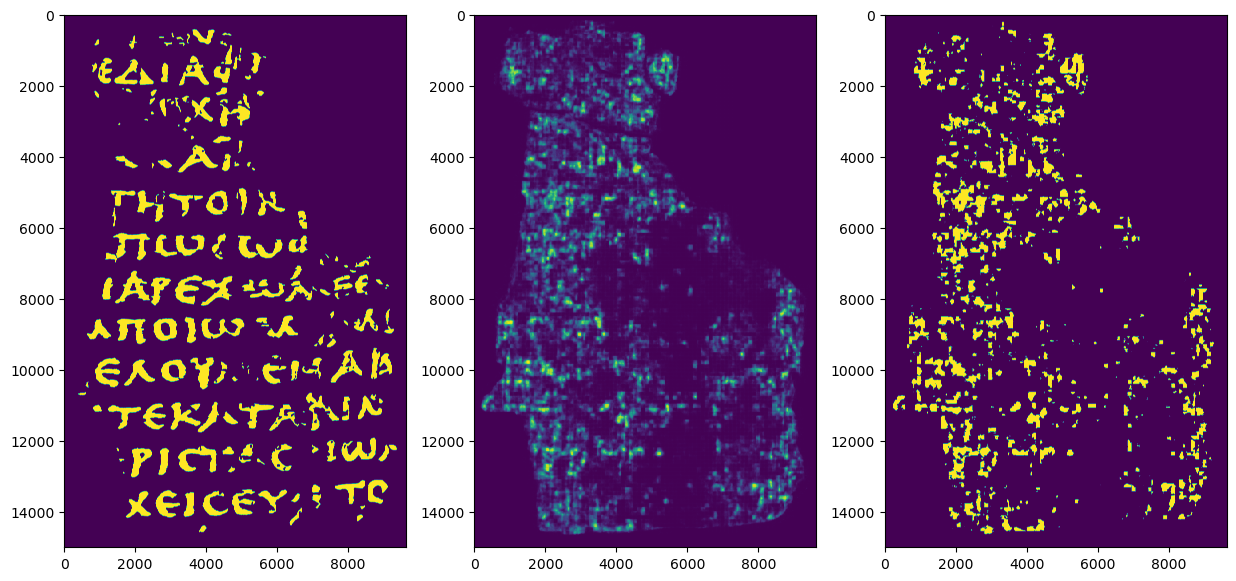

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.02927673e+08, 1.34332480e+07, 7.42130900e+06, 4.84373600e+06,
        3.46875100e+06, 2.66290300e+06, 1.99127800e+06, 1.55874600e+06,
        1.25296200e+06, 9.90760000e+05, 8.30437000e+05, 7.10328000e+05,
        6.15261000e+05, 5.07375000e+05, 4.29704000e+05, 3.50798000e+05,
        2.75374000e+05, 1.91018000e+05, 8.20570000e+04, 1.33380000e+04]),
 array([3.88503107e-19, 4.84887429e-02, 9.69774857e-02, 1.45466229e-01,
        1.93954971e-01, 2.42443714e-01, 2.90932457e-01, 3.39421200e-01,
        3.87909943e-01, 4.36398686e-01, 4.84887429e-01, 5.33376171e-01,
        5.81864914e-01, 6.30353657e-01, 6.78842400e-01, 7.27331143e-01,
        7.75819886e-01, 8.24308629e-01, 8.72797371e-01, 9.21286114e-01,
        9.69774857e-01]),
 <BarContainer object of 20 artists>)

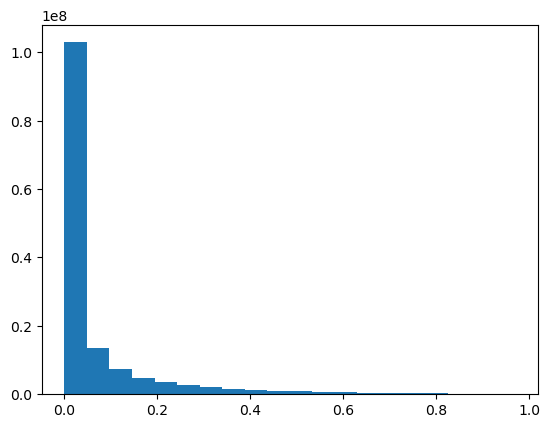

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000